# Imports

In [ ]:
# utilities
from operator import truediv
import os
import csv
import time
import numpy as np
from google.colab import files, drive

# image processing
from scipy import ndimage
from skimage import io, color

# visualization
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Helper Functions

In [ ]:
def float_to_int(img):
    return (img*255).astype(np.uint8)

In [ ]:
def generate_csv(filepaths, root):
    root_name = root.split("/")[-1]
    open_file = open(f'{root}/{root_name}_metadata.csv', 'w', newline='', encoding='utf-8')
    csv_file  = csv.writer(open_file)
    csv_file.writerow(['DIR', 'DATE', 'CLASS_NAME', 'OBJ-ID', 'BACKGROUND', 'LIGHT', 'INDOOR'])

    for filepath in filepaths:
        folders = filepath.split('/')
        obj_id = folders[-1].split('.')[0]
        class_name = folders[-2]
        background = folders[-3]
        indoor = folders[-4]
        isIndoor = True if indoor == 'interior' else False
        light = folders[-5]

        csv_file.writerow([filepath, time.ctime(os.path.getmtime(filepath)), class_name, obj_id, background, light, isIndoor])
    
    open_file.close()

    return

In [ ]:
# list_filepaths(): list filepath for every filepath on a root folder
# pre-condition: (root path, empty list)
# post-condition: list with every filepath on root path
def list_filepaths(path, filepaths = []):
    for filename in os.listdir(path):
        if 'csv' not in filename: # rejects csvs
            filepath = os.path.join(path, filename)
            if os.path.isfile(filepath): filepaths.append(filepath) # Adiciona apenas caminhos que são de arquivos (que no nosso caso são imagens)
            else: list_filepaths(filepath, filepaths)

    return filepaths

In [ ]:
# generates gradient mask
# pre-condition: (row, column)
# post-condition: returns a (row, column) gradient mask from black to white in the column direction
def generate_gradient(rows, columns):
    gradient_range = np.linspace(0, 1, columns) # black to white [0,1]
    gradient = np.tile(gradient_range, (rows, 1))  # tiles gradient_range row times

    return gradient

# Pipeline

In [ ]:
# 0 FILE READING

drive.mount('/content/drive')
root = '/content/drive/MyDrive/Colab/MAC0417/Trabalho'
grayData_path = root + '/originalGreyDataSet'
originalData_path = root + '/originalDataSet'
augumentedData_path = root + '/augmentedDataSet'

original_filepaths = list_filepaths(originalData_path, [])
print(f'# of images: {len(original_filepaths)}')

generate_csv(original_filepaths, originalData_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
# of images: 441


In [ ]:
# GENERATE IMAGES

rr, cc, ch = io.imread(original_filepaths[0]).shape
gradient_mask = generate_gradient(rr, cc)
kernel = np.ones([3,3])/9

for img_path in original_filepaths:
    # read
    img = io.imread(img_path)
    filename = img_path.split('/')[-1]
    middle_path = img_path.replace(originalData_path, '').replace(filename, '')

    # generate
    img_gray = color.rgb2gray(img) # 1 RGB -> GRAYSCALE
    img_log = np.log2(img_gray + 1) # 2 LOG: s = c * log (1 + r) onde c = 1
    img_median = ndimage.convolve(img_gray, kernel, mode='nearest', cval=0.0) # 3 MEDIAN FILTER by convolution
    img_gradient  = np.multiply(img_gray, gradient_mask) # 4 GRADIENT
    img_exponential = (np.exp(img_gray + 1) - np.exp(1)) / (np.exp(2)-np.exp(1)) # 5 EXPONENTIAL s = exp(img)

    # write
    if not os.path.isdir(grayData_path + middle_path): os.makedirs(grayData_path + middle_path)
    if not os.path.isdir(augumentedData_path + middle_path): os.makedirs(augumentedData_path + middle_path)

    io.imsave(img_path.replace(originalData_path, grayData_path), float_to_int(img_gray))
    io.imsave(img_path.replace(originalData_path, augumentedData_path), float_to_int(img_gray))
    io.imsave(img_path.replace(originalData_path, augumentedData_path).replace(filename, f'log_{filename}'), float_to_int(img_log))
    io.imsave(img_path.replace(originalData_path, augumentedData_path).replace(filename, f'median_{filename}'), float_to_int(img_median))
    io.imsave(img_path.replace(originalData_path, augumentedData_path).replace(filename, f'gradient_{filename}'), float_to_int(img_gradient))
    io.imsave(img_path.replace(originalData_path, augumentedData_path).replace(filename, f'exponential_{filename}'), float_to_int(img_exponential))

generate_csv(list_filepaths(grayData_path, []), grayData_path)
generate_csv(list_filepaths(augumentedData_path, []), augumentedData_path)

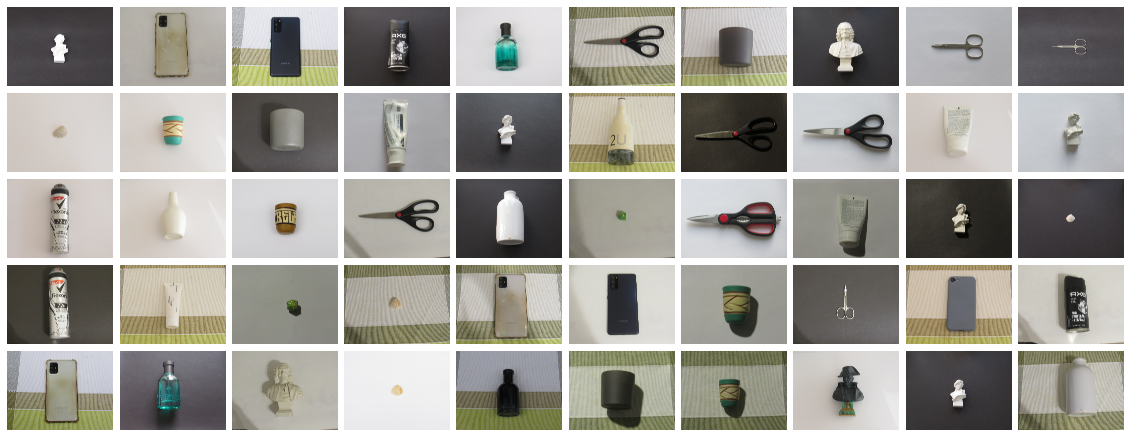

In [45]:
# GENERATE PREVIEW
rng = np.random.default_rng()
rng_idx = rng.choice(len(original_filepaths), size=50, replace=False)

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1)

for ax, idx in zip(grid, rng_idx):
    ax.imshow(io.imread(original_filepaths[idx]), cmap=plt.cm.gray)
    ax.axis("off")

fig.savefig(f'{originalData_path}/datasetPreview.png', dpi=300)
plt.show()
plt.close()

[timestamp] 1657416655.3433323
shape: (3456, 4608, 3)
intensity range: 13, 230
[1] grayscale


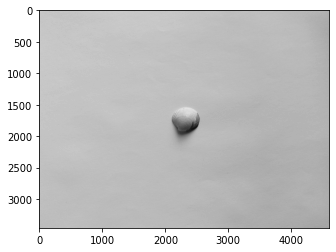

intensity range: 0.11020392156862745, 0.8825392156862745
[2] gradient


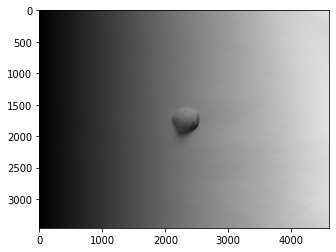

intensity range: 0.0, 0.7339482166524086
[3] log


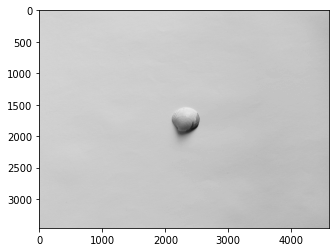

intensity range: 0.15082469424673875, 0.9126799183829041
[4] exponential


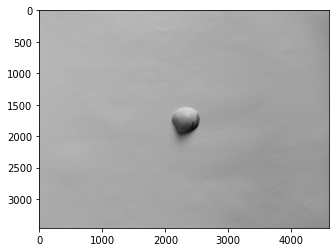

intensity range: 0.06780361924082087, 0.8246780336968177
[5] median


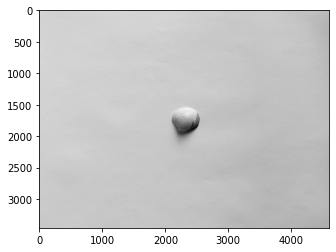

intensity range: 0.13293124183006536, 0.834043311546841


In [ ]:
# TEST IMAGE

ts = time.time()
print(f'[timestamp] {ts}')

test_idx = np.random.randint(len(original_filepaths)) # chooses a random image
img = io.imread(original_filepaths[0])
rr, cc, ch = img.shape
print(f'shape: {img.shape}\nintensity range: {np.amin(img)}, {np.amax(img)}')

# 1 RGB -> GRAYSCALE
print('[1] grayscale')
img_gray = color.rgb2gray(img)
plt.imshow(float_to_int(img_gray), cmap=plt.cm.gray)
plt.show()
plt.close()
print(f'intensity range: {np.amin(img_gray)}, {np.amax(img_gray)}')

# 2 GRADIENT
print('[2] gradient')
gradient_mask = generate_gradient(rr, cc)
img_gradient  = np.multiply(img_gray, gradient_mask)
img_gray = color.rgb2gray(img)
plt.imshow(float_to_int(img_gradient), cmap=plt.cm.gray)
plt.show()
plt.close()
print(f'intensity range: {np.amin(img_gradient)}, {np.amax(img_gradient)}')

# 3 LOG
print('[3] log')
img_log = np.log2(img_gray + 1) # s = c * log (1 + r) onde c = 1
plt.imshow(float_to_int(img_log), cmap=plt.cm.gray)
plt.show()
plt.close()
print(f'intensity range: {np.amin(img_log)}, {np.amax(img_log)}')

# 4 EXPONENTIAL
print('[4] exponential')
img_exponential = (np.exp(img_gray + 1) - np.exp(1)) / (np.exp(2)-np.exp(1)) # s = exp(img)
plt.imshow(float_to_int(img_exponential), cmap=plt.cm.gray)
plt.show()
plt.close()
print(f'intensity range: {np.amin(img_exponential)}, {np.amax(img_exponential)}')

# 5 MEDIAN FILTER
print('[5] median')
kernel = np.ones([3,3])/9
img_median = ndimage.convolve(img_gray, kernel, mode='nearest', cval=0.0) # median by convolution
plt.imshow(float_to_int(img_median), cmap=plt.cm.gray)
plt.show()
plt.close()
print(f'intensity range: {np.amin(img_median)}, {np.amax(img_median)}')